<a href="https://colab.research.google.com/github/sahillakhmani/Natural-Language-Processing/blob/main/SkipgramNegativeSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4/5

In [ ]:
import os
import json
import gdown
import zipfile
from multiprocessing import Pool, cpu_count


# Step 1: Download the zipped corpus from Google Drive
def download_from_drive(drive_link, output_zip):
    gdown.download(drive_link, output_zip, quiet=False)

# Step 2: Extract the ZIP file
def extract_zip_file(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def main():
    drive_link = 'https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm'
    output_zip = 'corpus.zip'
    extract_to = 'extracted_corpus'
    download_from_drive(drive_link, output_zip)

    # Extract the ZIP file
    extract_zip_file(output_zip, extract_to)

if __name__ == "__main__":
    main()


Downloading...
From (original): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm
From (redirected): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&confirm=t&uuid=6c40aba2-3113-42e2-9308-c57ec45db900
To: /content/corpus.zip
100%|██████████| 1.00G/1.00G [00:10<00:00, 92.0MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
from multiprocessing import Pool, cpu_count

def json2text(filename):
    """
    Converts the JSON content of a file into a plain text format.

    Args:
    filename (str): Path to the JSON file.

    Returns:
    str: Extracted text content from the JSON file.
    """
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            paper_content = json.load(file)

        abstract = ""  # Initialize the abstract variable

        # Get the abstract
        if 'abstract' in paper_content:
            for abs in paper_content['abstract']:
                abstract += abs.get('text', '') + '\n'

            return abstract.strip()  # Return the collected abstract

        else:
            print(f"No abstract found in {filename}")
            return ""

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return ""

def process_and_collect(filename):
    """
    Process a single JSON file and return the extracted text.

    Args:
    filename (str): Path to the JSON file.

    Returns:
    str: Extracted text content.
    """
    return json2text(filename)

def par_process_json_files(json_folder, output_file):
    """
    Process all JSON files in a directory using multiprocessing and write their contents to a text file.

    Args:
    json_folder (str): Path to the folder containing JSON files.
    output_file (str): Path to the output text file.
    """
    json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]

    if not json_files:
        print(f"No JSON files found in {json_folder}")
        return

    cpu_count_ = cpu_count()
    with Pool(cpu_count_) as pool:
        processed_contents = pool.map(process_and_collect, json_files)

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for content in processed_contents:
            if content:  # Only write non-empty content
                outfile.write(content + '\n')

# Define paths (replace with your own paths if needed)
json_folder = r"/content/extracted_corpus/pdf_json"
output_file = r'/content/drive/MyDrive/abstracts.txt'

# Run the processing function
par_process_json_files(json_folder, output_file)
print(f"Processing complete. Output written to {output_file}")


Processing complete. Output written to /content/drive/MyDrive/abstracts.txt


In [ ]:
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download the stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of English stopwords from nltk
STOP_WORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans the text by removing special characters, digits, extra spaces,
    stop words, and words with length < 2.

    Args:
    text (str): Input text.

    Returns:
    str: Cleaned text.
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Filter out stop words and words with length < 2
    words = [word for word in text.split() if word not in STOP_WORDS and len(word) > 2]

    return ' '.join(words)

def build_vocabulary(input_file, vocab_size=10000):
    """
    Builds a vocabulary of the top `vocab_size` most frequent words from a text file,
    with corresponding indexes.

    Args:
    input_file (str): Path to the input text file.
    vocab_size (int): Size of the desired vocabulary.

    Returns:
    dict: Dictionary with words as keys and their indexes as values.
    """
    with open(input_file, 'r', encoding='utf-8') as file:
        text = file.read()

    # Clean the text
    cleaned_text = clean_text(text)

    # Tokenize the text into words
    words = cleaned_text.split()

    # Count word frequencies
    word_counts = Counter(words)

    # Get the top `vocab_size` most common words
    most_common_words = [word for word, _ in word_counts.most_common(vocab_size)]

    # Create a word-to-index mapping (dictionary)
    word_to_index = {word: idx for idx, word in enumerate(most_common_words)}

    return word_to_index

def save_vocabulary(vocab, output_file):
    """
    Saves the vocabulary to a text file, with each line containing the word and its index.

    Args:
    vocab (dict): Dictionary of words and their corresponding indexes.
    output_file (str): Path to the output text file.
    """
    with open(output_file, 'w', encoding='utf-8') as file:
        for word, index in vocab.items():
            file.write(f"{word}\t{index}\n")  # Save word and index separated by a tab

# Define paths
input_file = r'/content/drive/MyDrive/abstracts.txt'  # Input file path
vocab_output_file = r'/content/drive/MyDrive/vocabulary.txt'  # Output vocab file path

# Build and save the vocabulary
vocabulary = build_vocabulary(input_file, vocab_size=10000)
save_vocabulary(vocabulary, vocab_output_file)

print(f"Vocabulary of 10,000 words with indexes saved to {vocab_output_file}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Vocabulary of 10,000 words with indexes saved to /content/drive/MyDrive/vocabulary.txt


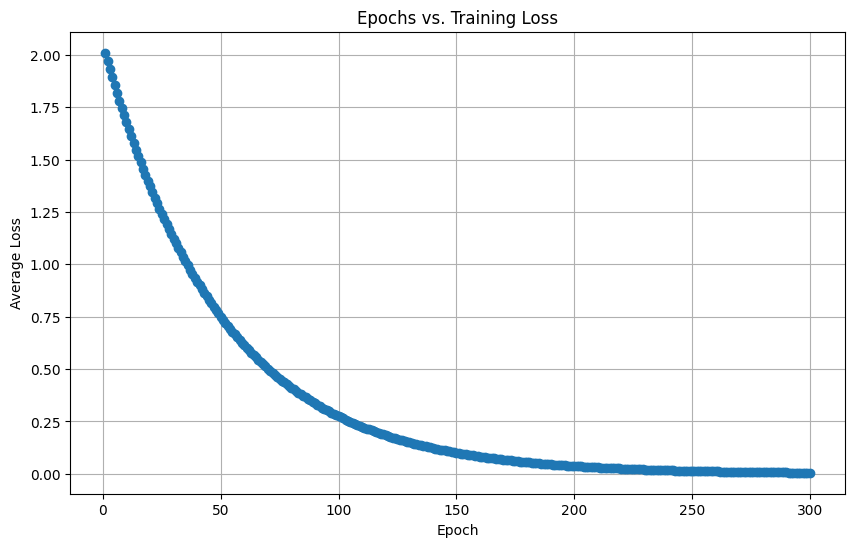

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def build_vocabulary_index(vocab_file):
    """
    Creates a word-to-index mapping from a vocabulary file.
    """
    with open(vocab_file, 'r', encoding='utf-8') as file:
        word_to_index = {
            line.split('\t')[0]: int(line.split('\t')[1])  # Extract word and index
            for line in file.readlines()
        }
    return word_to_index

def one_hot_vector_from_index(index, vocab_size):
    """
    Generates a one-hot vector using the provided index.
    """
    vector = np.zeros(vocab_size)
    vector[index] = 1
    return vector

def sgd_step(x, y, weights, learning_rate):
    """
    Performs a single step of Stochastic Gradient Descent (SGD).
    """
    y_hat = np.dot(weights, x)  # Prediction: y_hat = w.T * x
    error = y_hat - y  # Error: error = y_hat - y
    grad = error * x  # Gradient: grad = error * x
    weights -= learning_rate * grad  # Update weights
    return weights

def train_sgd(vocab_file, learning_rate=0.01, epochs=100):
    """
    Trains a model using SGD and stores the average loss for each epoch.
    """
    # Build vocabulary index and determine its size
    word_to_index = build_vocabulary_index(vocab_file)
    vocab_size = len(word_to_index)

    # Initialize random weights
    weights = np.random.randn(vocab_size)

    # Dummy target value for each word (1.0 for simplicity)
    target = 1.0

    # Store average loss for each epoch
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0

        # Perform SGD for each word in the vocabulary
        for word, index in word_to_index.items():
            x = one_hot_vector_from_index(index, vocab_size)  # One-hot vector
            weights = sgd_step(x, target, weights, learning_rate)  # SGD step

            # Calculate MSE loss for monitoring
            y_hat = np.dot(weights, x)
            loss = (y_hat - target) ** 2
            total_loss += loss

        # Calculate and store average loss for the epoch
        avg_loss = total_loss / vocab_size
        epoch_losses.append(avg_loss)
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot the training loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title("Epochs vs. Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()

# Example usage:
vocab_file = r'/content/drive/MyDrive/vocabulary.txt'  # Path to the vocabulary file

# Train the model and plot the loss
train_sgd(vocab_file, learning_rate=0.01, epochs=300)


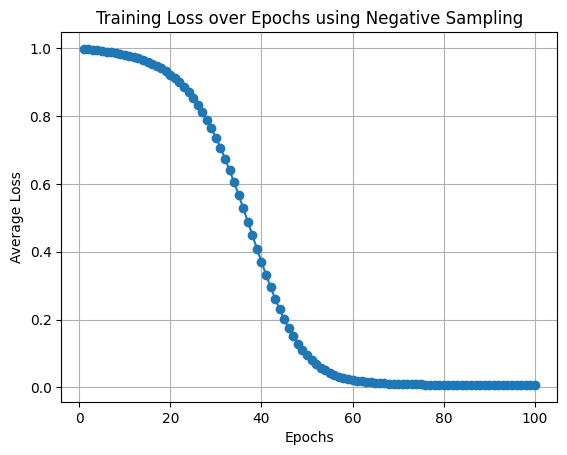

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def one_hot_vector_from_index(index, vocab_size):
    """Generates a one-hot vector using the provided index."""
    vector = np.zeros(vocab_size)
    vector[index] = 1
    return vector

def negative_sampling(target_word_index, word_to_index, num_neg_samples=5):
    """Sample negative words for the given target word index."""
    all_indices = list(word_to_index.values())
    all_indices.remove(target_word_index)  # Exclude the target word
    negative_samples = random.sample(all_indices, num_neg_samples)
    return negative_samples

def sgd_step(W_in, W_out, input_index, positive_index, negative_indices, learning_rate):
    """Performs a single SGD step updating W_in and W_out."""
    # Retrieve input and target word embeddings
    h = W_in[input_index]   # Hidden layer (embedding for input word)
    u_pos = W_out[positive_index]  # Positive sample

    # Positive sample update
    y_hat_pos = np.dot(u_pos, h)  # Prediction for positive sample
    error_pos = y_hat_pos - 1     # Target is 1 for positive sample

    W_out[positive_index] -= learning_rate * error_pos * h  # Update W_out
    W_in[input_index] -= learning_rate * error_pos * u_pos  # Update W_in

    # Negative samples update
    for neg_index in negative_indices:
        u_neg = W_out[neg_index]  # Negative sample embedding
        y_hat_neg = np.dot(u_neg, h)  # Prediction for negative sample
        error_neg = y_hat_neg  # Target is 0 for negative samples

        W_out[neg_index] -= learning_rate * error_neg * h  # Update W_out
        W_in[input_index] -= learning_rate * error_neg * u_neg  # Update W_in

def train_skipgram(vocab_file, embedding_dim=50, learning_rate=0.01, epochs=10, num_neg_samples=5):
    """Trains the Skip-gram model with W_in and W_out."""
    word_to_index = build_vocabulary_index(vocab_file)
    vocab_size = len(word_to_index)

    # Initialize W_in and W_out with small random values
    W_in = np.random.randn(vocab_size, embedding_dim) * 0.01
    W_out = np.random.randn(vocab_size, embedding_dim) * 0.01

    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0

        for word, input_index in word_to_index.items():
            # Sample positive and negative words
            positive_index = input_index
            negative_indices = negative_sampling(input_index, word_to_index, num_neg_samples)

            # Perform SGD step
            sgd_step(W_in, W_out, input_index, positive_index, negative_indices, learning_rate)

            # Calculate loss for monitoring
            y_hat = np.dot(W_out[positive_index], W_in[input_index])
            loss = (y_hat - 1) ** 2  # Loss for positive sample
            total_loss += loss

        avg_loss = total_loss / vocab_size
        epoch_losses.append(avg_loss)

    # Plot the loss over epochs
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.title('Training Loss over Epochs using Negative Sampling')
    plt.grid(True)
    plt.show()

    return W_in, W_out, word_to_index

def build_vocabulary_index(vocab_file):
    """Creates a word-to-index mapping from the vocabulary file."""
    with open(vocab_file, 'r', encoding='utf-8') as file:
        word_to_index = {
            line.split('\t')[0]: int(line.split('\t')[1])
            for line in file.readlines()
        }
    return word_to_index

def cosine_similarity(vec1, vec2):
    """Calculates cosine similarity between two vectors."""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def word_analogy(word_a, word_b, word_c, W_in, word_to_index):
    """
    Solves the analogy: word_a : word_b :: word_c : ?
    Uses cosine similarity to find the best matching word.
    """
    if any(w not in word_to_index for w in [word_a, word_b, word_c]):
        raise ValueError("One or more words not in vocabulary.")

    # Get embeddings for the words
    vec_a = W_in[word_to_index[word_a]]
    vec_b = W_in[word_to_index[word_b]]
    vec_c = W_in[word_to_index[word_c]]

    # Calculate the target vector: vec_b - vec_a + vec_c
    target_vec = vec_b - vec_a + vec_c

    # Find the most similar word to the target vector
    best_word = None
    best_similarity = -1

    for word, index in word_to_index.items():
        if word in [word_a, word_b, word_c]:  # Skip input words
            continue
        similarity = cosine_similarity(W_in[index], target_vec)
        if similarity > best_similarity:
            best_similarity = similarity
            best_word = word

    return best_word

# Example usage
vocab_file = '/content/drive/MyDrive/vocabulary.txt'  # Path to vocabulary file

# Train the Skip-gram model and get W_in and W_out matrices
W_in, W_out, word_to_index = train_skipgram(vocab_file, embedding_dim=50, learning_rate=0.07, epochs=100)



## Architecture Overview: Word2Vec with Skip-Gram Model and Negative Sampling
The Skip-Gram Word2Vec model used in this project is designed to learn word embeddings by predicting context words given a target word. The architecture focuses on two primary matrices:

**W_in**: Connects the input layer to the hidden layer (used as the word embeddings).

**W_out**: Connects the hidden layer to the output layer (used for predictions but often ignored during inference).

The negative sampling strategy simplifies the computational requirements by updating only a small set of negative samples during each step, rather than the full vocabulary.

###Architecture Flow
**Input Layer:**
One-hot encoded vector representing a target word.

**Dimensionality:**
vocab_size × 1
vocab_size × 1.

**Hidden Layer:**
A dense layer with size embedding_dim (e.g., 50). This layer serves as the word embedding layer.

**Matrix:** W_in with shape
vocab_size
×
embedding_dim
vocab_size×embedding_dim.
Each row in W_in represents the embedding of a word.

**Output Layer:**
A second dense layer that produces a score for each possible context word.
Matrix: W_out with shape
vocab_size
×
embedding_dim
vocab_size×embedding_dim.
During negative sampling, only selected rows of W_out are used.
Key Design Decisions
Skip-Gram Model:
We chose a Skip-Gram architecture because it captures fine-grained word relationships, useful for tasks like word similarity and analogy detection.

**Embedding Size:**
The embedding dimension (e.g., 50) is small enough for efficient learning yet sufficient to capture semantic meaning.

**Negative Sampling:**
Instead of a full softmax over all possible context words, we sample a few negative examples, making training faster and more scalable.

**Learning Rate Decay:**
A decreasing learning rate ensures convergence while avoiding overshooting during later epochs.

In [ ]:
# Find word analogy: 'king' is to 'man' as 'queen' is to ?
analogy_result = word_analogy('vaccine', 'immunity', 'disease', W_in, word_to_index)
print(f"'vaccine' is to 'immunity' as 'disease' is to '{analogy_result}'")

'vaccine' is to 'immunity' as 'disease' is to 'immobilized'


In [ ]:
def find_similar_words(word, W_in, word_to_index, top_n=5):
    """
    Finds the top_n words similar to the given word based on the average of W_in and W_out.
    Cosine similarity is used as the metric.
    """
    if word not in word_to_index:
        raise ValueError(f"'{word}' is not in the vocabulary.")

    # Get the embedding of the word (averaging W_in and W_out)
    input_index = word_to_index[word]
    word_vector = W_in[input_index]

    similarities = []

    # Calculate cosine similarity between the input word and all other words
    for other_word, other_index in word_to_index.items():
        if other_word != word:  # Skip the input word itself
            other_vector = W_in[other_index]
            similarity = cosine_similarity(word_vector, other_vector)
            similarities.append((other_word, similarity))

    # Sort by similarity and return the top_n most similar words
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage: Finding similar words for 'vaccine'
similar_words = find_similar_words('disease', W_in, word_to_index, top_n=5)
print(f"Words similar to 'disease' using W_in: {similar_words}")


Words similar to 'disease' using W_in: [('rapidly', 0.5120617176591599), ('switch', 0.4850820467416592), ('delineate', 0.46380812942129007), ('behavioral', 0.4586317586754055), ('hydroxychloroquine', 0.4479161616312259)]


In [ ]:
def find_similar_words2(word, W_out, word_to_index, top_n=5):
    """
    Finds the top_n words similar to the given word based on the average of W_in and W_out.
    Cosine similarity is used as the metric.
    """
    if word not in word_to_index:
        raise ValueError(f"'{word}' is not in the vocabulary.")

    # Get the embedding of the word (averaging W_in and W_out)
    input_index = word_to_index[word]
    word_vector = W_out[input_index]

    similarities = []

    # Calculate cosine similarity between the input word and all other words
    for other_word, other_index in word_to_index.items():
        if other_word != word:  # Skip the input word itself
            other_vector = W_out[other_index]
            similarity = cosine_similarity(word_vector, other_vector)
            similarities.append((other_word, similarity))

    # Sort by similarity and return the top_n most similar words
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage: Finding similar words for 'vaccine'
similar_words = find_similar_words2('disease', W_out, word_to_index, top_n=5)
print(f"Words similar to 'disease' using W_out: {similar_words}")


Words similar to 'disease' using W_out: [('rapidly', 0.5224999603156085), ('switch', 0.46219031377535363), ('travelling', 0.45647931223102706), ('hydroxychloroquine', 0.45263198785288866), ('realistic', 0.44144198265219553)]


In [ ]:
def find_similar_words3(word, W_in, W_out, word_to_index, top_n=5):
    """
    Finds the top_n words similar to the given word based on the average of W_in and W_out.
    Cosine similarity is used as the metric.
    """
    if word not in word_to_index:
        raise ValueError(f"'{word}' is not in the vocabulary.")

    # Get the embedding of the word (averaging W_in and W_out)
    input_index = word_to_index[word]
    word_vector = (W_out[input_index]+W_in[input_index])/2

    similarities = []

    # Calculate cosine similarity between the input word and all other words
    for other_word, other_index in word_to_index.items():
        if other_word != word:  # Skip the input word itself
            other_vector = (W_out[other_index]+W_in[other_index])/2
            similarity = cosine_similarity(word_vector, other_vector)
            similarities.append((other_word, similarity))

    # Sort by similarity and return the top_n most similar words
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage: Finding similar words for 'vaccine'
similar_words = find_similar_words3('disease', W_in, W_out, word_to_index, top_n=5)
print(f"Words similar to 'disease' using both W_in and W_out: {similar_words}")


Words similar to 'disease' using both W_in and W_out: [('rapidly', 0.5206129228506454), ('switch', 0.47746685816136714), ('hydroxychloroquine', 0.45356088626295266), ('delineate', 0.4514840199374046), ('behavioral', 0.44880851248676246)]


## Brief Description of the Outcome

**Consistency Across Approaches:**

Similar to the results for "vaccine," there is a notable consistency in the top similar words across all three approaches. "Rapidly" ranks the highest in all three methods, showing a strong association with "disease." Additionally, "switch" and "hydroxychloroquine" appear in all lists, demonstrating these words' consistent connection with "disease."

**Variations in Similarities:**

The similarities reveal different contextual relationships. For example:
In the W_out approach, "travelling" and "realistic" are among the top similar words, but they do not appear in the W_in results. This suggests that W_out captures a broader context where disease might relate to concepts like movement and practicality.
In contrast, the W_in results contain more specialized terms like "delineate" and "behavioral," indicating a different aspect of the semantic relationship, potentially focused on medical or behavioral contexts.
Impact of Averaging: The averaged results again provide a middle ground, with words like "delineate" and "behavioral" from W_in being retained, while "travelling" from W_out is dropped. This shows that averaging helps to balance and smooth out the differences between the two embeddings, maintaining both technical and contextual associations.

**Diverse Word Choices:**

The appearance of technical terms like "hydroxychloroquine" across all approaches highlights how both input and output embeddings can capture medically relevant concepts.
Words like "rapidly" and "switch" suggest that the model associates "disease" with dynamic or changing processes, while "behavioral" and "delineate" suggest an emphasis on how diseases are described or understood in different contexts.

## **Task 5**

There are no errors in the slides that I could find.